In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import os
from keras import regularizers
import random
from skimage.filters import threshold_otsu
from skimage import measure
from skimage import filters
import matplotlib.pyplot as plt
import glob
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf 
import tensorflow.keras as keras
from sklearn.utils import shuffle
from keras.models import Model,Sequential
from keras.layers import Input,Conv2D, Dense, Flatten ,Dropout ,MaxPooling2D, GlobalAveragePooling2D 
from keras.callbacks import EarlyStopping 
from keras.optimizers import Adam 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from keras.preprocessing import image
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input


In [4]:
# Add file paths
PYes = r'D:\OneDrive_1_26-3-2024\yes\*'
PNo = r'D:\OneDrive_1_26-3-2024\no\*'

tumor_yes = []
tumor_no = []

for File in glob.iglob(PYes):
    Image = cv2.imread(File)  
    Image = cv2.cvtColor(Image, cv2.COLOR_BGR2RGB)  #OpenCV reads images in BGR format by default 
    Image = cv2.resize(Image, (128, 128)) 
    tumor_yes.append((Image, 1))  #Labeling tuomrs images with '1'

for File in glob.iglob(PNo):
    Image = cv2.imread(File)
    Image = cv2.cvtColor(Image, cv2.COLOR_BGR2RGB)
    Image = cv2.resize(Image, (128, 128))
    tumor_no.append((Image, 0))  #Labeling healthy images with '0'

AllData =  tumor_yes + tumor_no
Images = [] 
Labels = []
for i in AllData:
    Images.append(i[0])
    Labels.append(i[1])

Images = np.array(Images)
Labels = np.array(Labels)
print(len(Labels))

7198


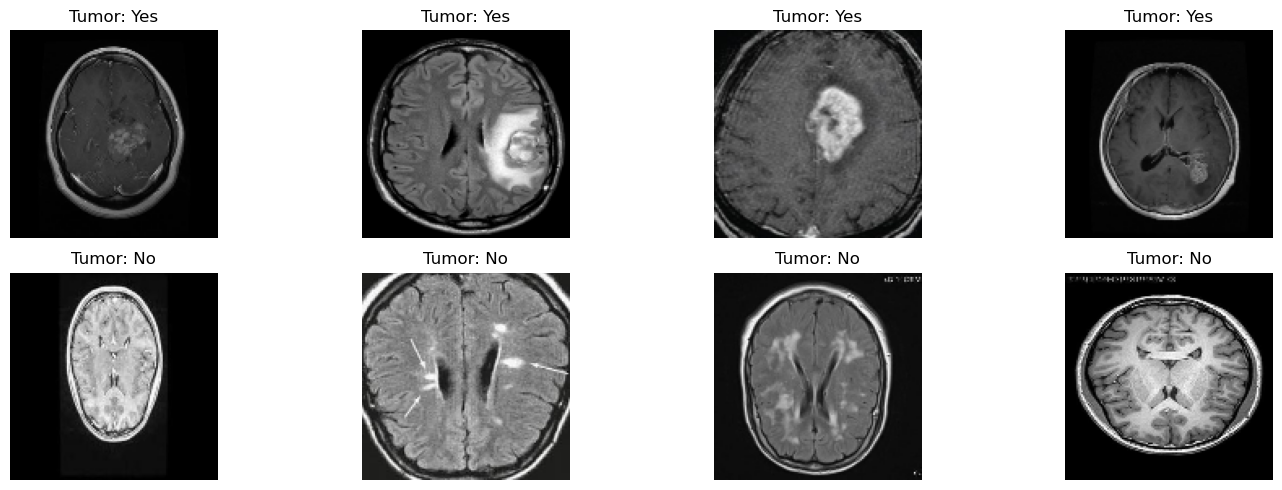

In [5]:
#let's take a look into the dataset 
fig, axes = plt.subplots(2, 4, figsize=(15, 5))

#display images with tumor
for i in range(4):
    axes[0, i].imshow(tumor_yes[i][0])  
    axes[0, i].set_title("Tumor: Yes")  
    axes[0, i].axis('off')

# Display images without tumor
for i in range(4):
    axes[1, i].imshow(tumor_no[i][0])  
    axes[1, i].set_title("Tumor: No")  
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

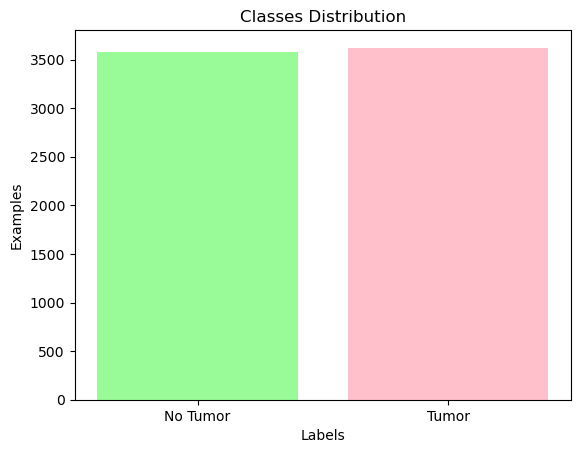

In [6]:
# checking if the dataset is balanced
Unique, LabelsNumber = np.unique(Labels, return_counts=True)

Class_Labels = ['No Tumor', 'Tumor']
Class_Colors = ['palegreen', 'pink']

plt.bar(Class_Labels, LabelsNumber, color=Class_Colors)
plt.xlabel('Labels')
plt.ylabel('Examples')
plt.title('Classes Distribution')

plt.xticks(Class_Labels)

plt.show()

In [7]:
#we want to crop the image to focus on the brain 
def BTD_Preprocess(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply histogram equalization
    equalized = cv2.equalizeHist(gray)

    # Apply Gaussian filtering to reduce noise
    blurred = cv2.GaussianBlur(equalized, (3, 3), 0)
    
    _, thresholded = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(contour)
    cropped_image = image[y:y+h, x:x+w]
    
    # Enhance brain features
    enhanced_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2HSV)
    enhanced_image[:,:,1] = cv2.equalizeHist(enhanced_image[:,:,1])
    enhanced_image = cv2.cvtColor(enhanced_image, cv2.COLOR_HSV2RGB)
    
    #Normalizing from 0-255 to 0-1
    Normalized_Image = enhanced_image / 255
    
    # Resize the image to match CNN input size
    resized_image = cv2.resize(Normalized_Image, (128, 128))
    
    return resized_image



In [8]:
ready_Images =[]

for i in Images:
  processed_Img = BTD_Preprocess(i)
  ready_Images.append(processed_Img)


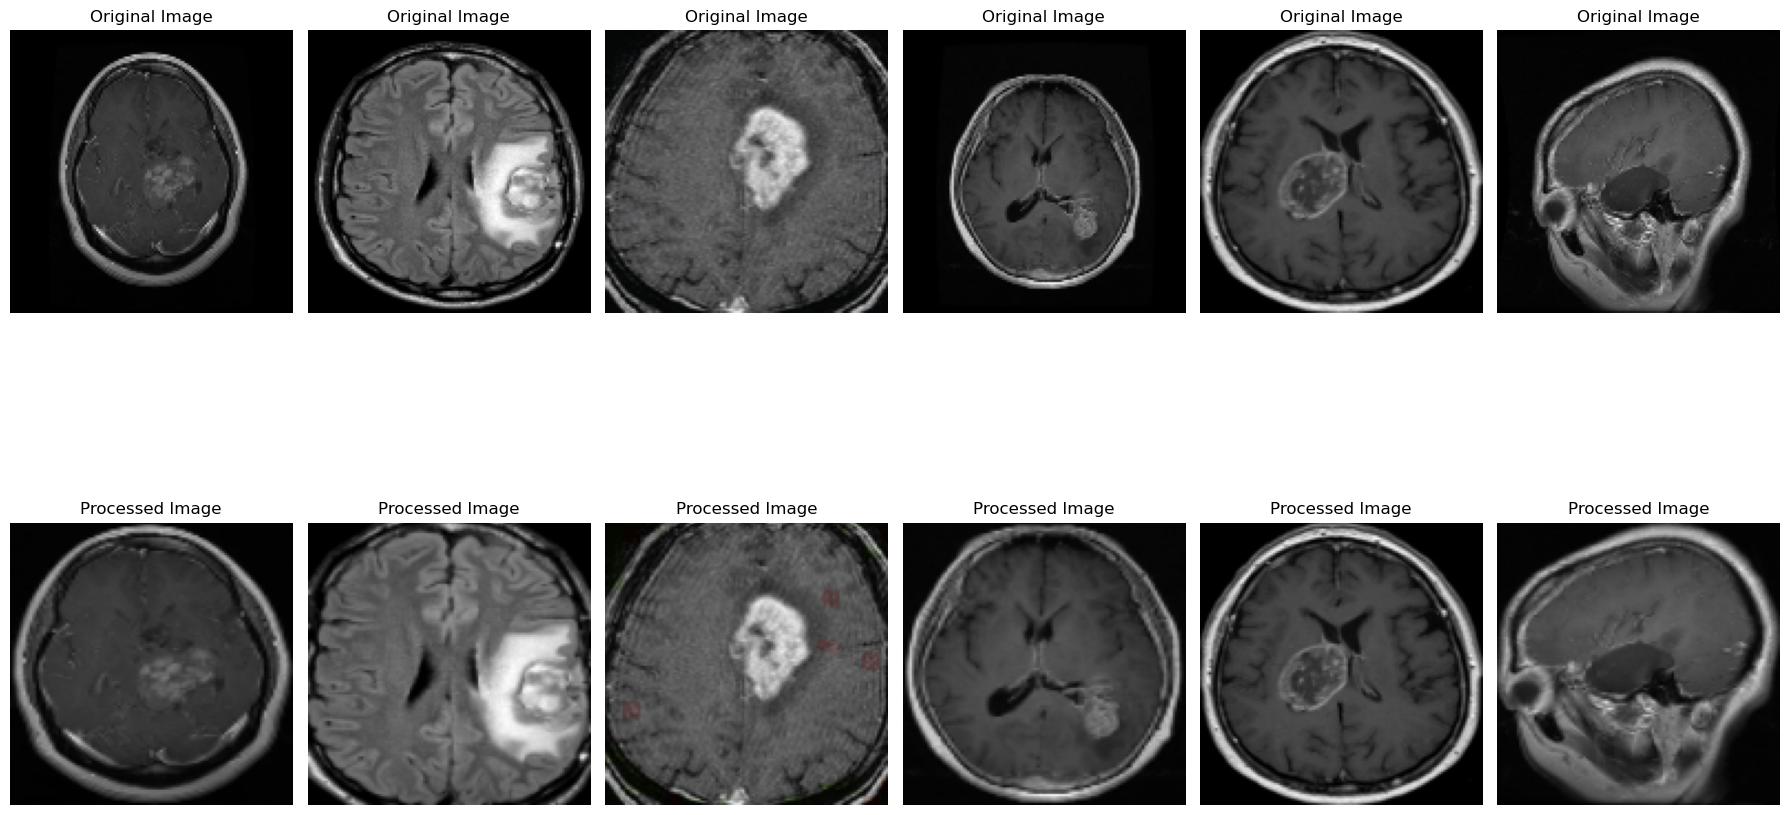

In [9]:

n = 6

fig, axes = plt.subplots(2, n, figsize=(18, 12))

for i in range(n):
    axes[0, i].imshow(Images[i])
    axes[0, i].set_title("Original Image")
    axes[0, i].axis("off")

for i in range(n):
    axes[1, i].imshow(ready_Images[i])
    axes[1, i].set_title("Processed Image")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

In [10]:
ready_Images=np.array(ready_Images)

#andomizing images
ShuffleImgs, ShuffleLabels = shuffle( ready_Images, Labels, random_state=27)

train_Imgs, test_Imgs, train_Labels, test_Labels = train_test_split(ShuffleImgs, ShuffleLabels, test_size=0.2, random_state=27)
test_Imgs, val_Imgs, test_Labels, val_Labels = train_test_split(test_Imgs, test_Labels, test_size=0.45, random_state=27)
 
# Check label distribution in train set
train_label_counts = Counter(train_Labels)
print("Train label distribution:", train_label_counts)

# Check label distribution in validation set
val_label_counts = Counter(val_Labels)
print("Validation label distribution:", val_label_counts)

# Check label distribution in test set
test_label_counts = Counter(test_Labels)
print("Test label distribution:", test_label_counts)

Train label distribution: Counter({1: 2880, 0: 2878})
Validation label distribution: Counter({1: 334, 0: 314})
Test label distribution: Counter({1: 408, 0: 384})


In [11]:
input_shape=(128, 128, 3)
BrainModel = Sequential()
    # Convolutional layers
BrainModel.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.005)))
BrainModel.add(MaxPooling2D((2, 2)))
BrainModel.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.005)))
BrainModel.add(MaxPooling2D((2, 2)))
BrainModel.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005)))
BrainModel.add(MaxPooling2D((2, 2)))
BrainModel.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005)))
BrainModel.add(MaxPooling2D((2, 2)))
# Flatten the output from convolutional layers
BrainModel.add(Flatten())
BrainModel.add(Dropout(0.4))
BrainModel.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
BrainModel.add(Dropout(0.4))
BrainModel.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.004)))

print(BrainModel.summary())




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)      

In [12]:
Epochs = 30
Batch_size = 32 
# Define the early stopping callback
EarlyStop = EarlyStopping(patience=4, monitor='val_loss')
learning_rate = 1e-4  
optimizer = Adam(learning_rate = learning_rate)
BrainModel.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=optimizer)

# Train the model with early stopping
history = BrainModel.fit(train_Imgs, 
                         train_Labels,
                         batch_size=Batch_size,
                         epochs=Epochs,
                         validation_data=(val_Imgs, val_Labels),
                         callbacks=[EarlyStop])

Epoch 1/30


180/180 [==============================] - 31s 163ms/step - loss: 2.4050 - accuracy: 0.5627 - val_loss: 1.6779 - val_accuracy: 0.6528
Epoch 2/30
180/180 [==============================] - 29s 163ms/step - loss: 1.3550 - accuracy: 0.7094 - val_loss: 1.1081 - val_accuracy: 0.7670
Epoch 3/30
180/180 [==============================] - 31s 170ms/step - loss: 1.0264 - accuracy: 0.7800 - val_loss: 0.9164 - val_accuracy: 0.8040
Epoch 4/30
180/180 [==============================] - 41s 226ms/step - loss: 0.8665 - accuracy: 0.8164 - val_loss: 0.8046 - val_accuracy: 0.8318
Epoch 5/30
180/180 [==============================] - 31s 169ms/step - loss: 0.7697 - accuracy: 0.8383 - val_loss: 0.7283 - val_accuracy: 0.8488
Epoch 6/30
180/180 [==============================] - 31s 172ms/step - loss: 0.6969 - accuracy: 0.8651 - val_loss: 0.6590 - val_accuracy: 0.8719
Epoch 7/30
180/180 [==============================] - 50s 277ms/step - loss: 0.6234 - accuracy: 0.8906 - val_loss: 0.5971 - val_

21/21 [==============================] - 1s 54ms/step
Validation Set Accuracy: 97.685 %


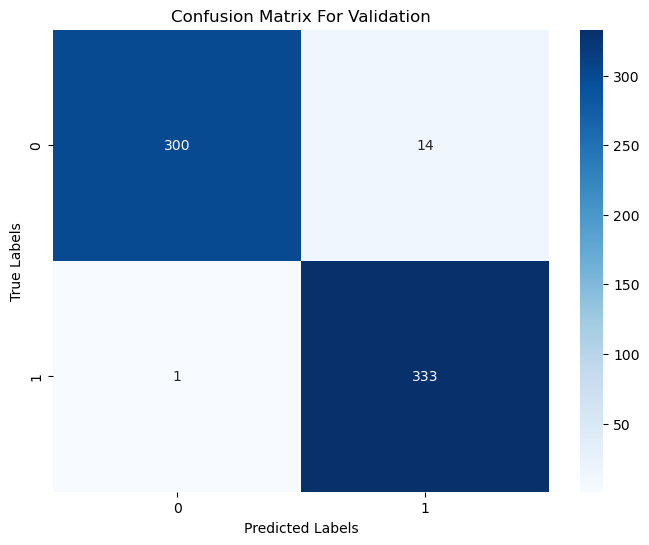

In [13]:
OursPredictions = BrainModel.predict(val_Imgs)
Threshold = 0.5 
Bi_Predictions = (OursPredictions > Threshold).astype(int)

conf= confusion_matrix(val_Labels, Bi_Predictions)

accuracy = accuracy_score(val_Labels, Bi_Predictions)
print("Validation Set Accuracy: {:.3f} %".format(accuracy*100))


plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

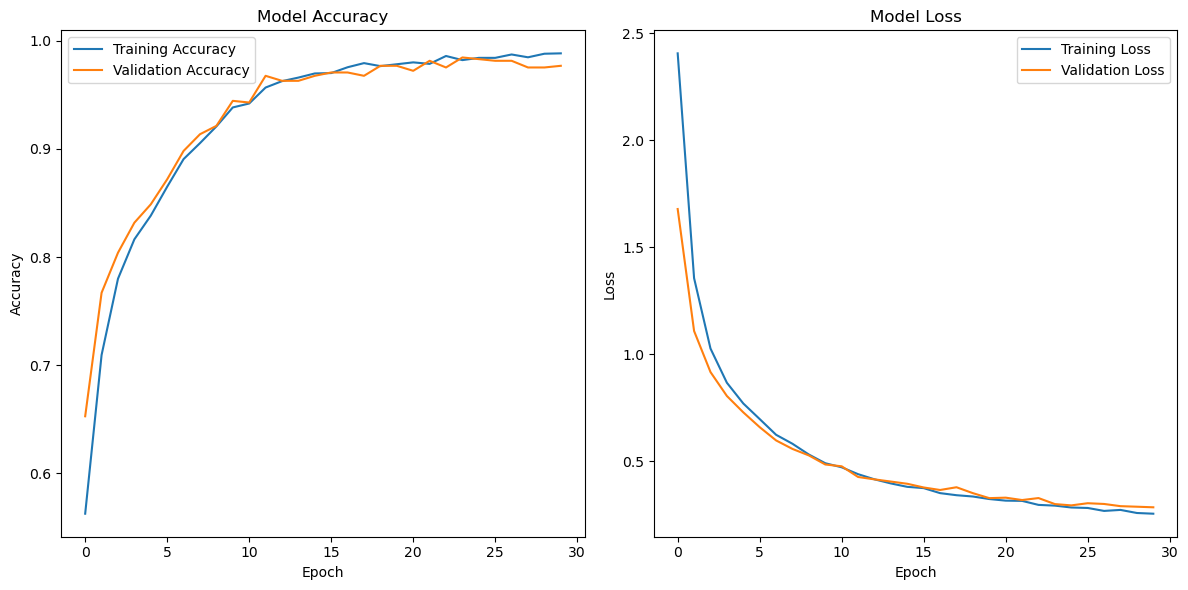

In [14]:
# Plot the training and validation accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plot the training and validation loss
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(training_accuracy, label='Training Accuracy')
axs[0].plot(validation_accuracy, label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(training_loss, label='Training Loss')
axs[1].plot(validation_loss, label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()

plt.show()

25/25 [==============================] - 1s 54ms/step
Accuracy on Test Set: 98.232 %



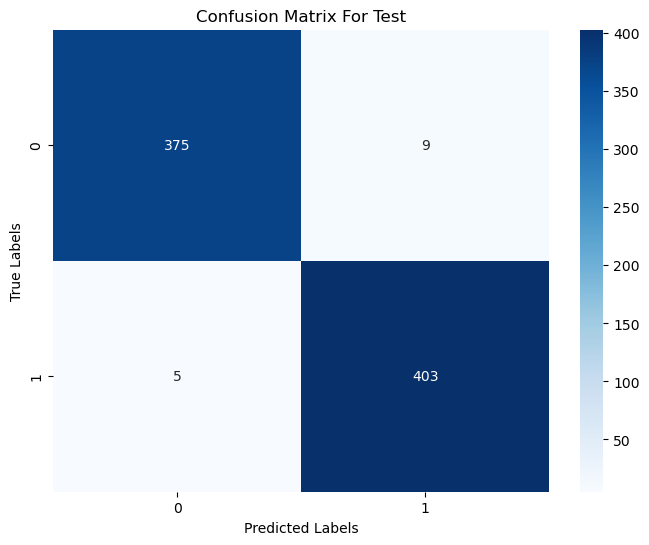

In [15]:
OursPredictions = BrainModel.predict(test_Imgs)
Threshold = 0.5 
Bi_Predictions = (OursPredictions > Threshold).astype(int)


conf_matrix = confusion_matrix(test_Labels, Bi_Predictions)

accuracy = accuracy_score(test_Labels, Bi_Predictions)
print("Accuracy on Test Set: {:.3f} %".format(accuracy*100))
print()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [16]:
# Classification Report
report = classification_report(test_Labels, Bi_Predictions)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       384
           1       0.98      0.99      0.98       408

    accuracy                           0.98       792
   macro avg       0.98      0.98      0.98       792
weighted avg       0.98      0.98      0.98       792



1/1 [==============================] - 0s 47ms/step
 Predicted class: Tumor


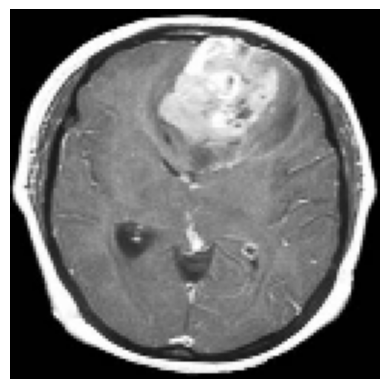

In [17]:
# Add the path of the image you want to test
image_path = r'D:\yes\13.jpg'  
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (128, 128)) 

processed_Img = BTD_Preprocess(image)

# Add an extra dimension to represent the batch size
processed_Img = np.expand_dims(processed_Img, axis=0)

# Make predictions on the input image
predictions = BrainModel.predict(processed_Img, 1)
threshold = 0.5 
binary_predictions = (predictions > threshold).astype(int)

# Display the image
plt.imshow(image)
plt.axis('off')

# Print the predicted class
if binary_predictions == 0:
    print (" Predicted class: No Tumor")
else:
    print(" Predicted class: Tumor")

# mobileNet:

In [16]:
import numpy as np
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# Load the pretrained MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid')(x)

# Create the final model
mobileNetModel = Model(inputs=base_model.input, outputs=output)

learning_rate = 1e-4
optimizer = Adam(learning_rate=learning_rate)
mobileNetModel.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=optimizer)

train_Imgs_preprocessed = preprocess_input(train_Imgs)
val_Imgs_preprocessed = preprocess_input(val_Imgs)
test_Imgs_preprocessed = preprocess_input(test_Imgs)

Epochs = 30
Batch_size = 32

history = mobileNetModel.fit(train_Imgs_preprocessed,
                             train_Labels,
                             batch_size=Batch_size,
                             epochs=Epochs,
                             validation_data=(val_Imgs_preprocessed, val_Labels),
                             callbacks=[EarlyStop])

Epoch 1/30
180/180 [==============================] - 61s 297ms/step - loss: 0.1689 - accuracy: 0.9345 - val_loss: 2.9730 - val_accuracy: 0.4846
Epoch 2/30
180/180 [==============================] - 54s 302ms/step - loss: 0.0251 - accuracy: 0.9941 - val_loss: 3.2586 - val_accuracy: 0.4861
Epoch 3/30
180/180 [==============================] - 64s 356ms/step - loss: 0.0164 - accuracy: 0.9960 - val_loss: 0.2813 - val_accuracy: 0.8951
Epoch 4/30
180/180 [==============================] - 65s 360ms/step - loss: 0.0145 - accuracy: 0.9958 - val_loss: 0.2206 - val_accuracy: 0.9074
Epoch 5/30
180/180 [==============================] - 66s 368ms/step - loss: 0.0141 - accuracy: 0.9953 - val_loss: 0.4823 - val_accuracy: 0.8318
Epoch 6/30
180/180 [==============================] - 61s 339ms/step - loss: 0.0080 - accuracy: 0.9977 - val_loss: 0.0747 - val_accuracy: 0.9738
Epoch 7/30
180/180 [==============================] - 61s 339ms/step - loss: 0.0079 - accuracy: 0.9972 - val_loss: 0.1937 - val_ac

In [17]:
# Evaluating on Validation set
val_predictions = mobileNetModel.predict(val_Imgs_preprocessed)
val_predictions_labels = np.round(val_predictions).flatten()

val_conf_matrix = confusion_matrix(val_Labels, val_predictions_labels)
val_accuracy = accuracy_score(val_Labels, val_predictions_labels)

print("Accuracy on Validation Set: {:.3f}%".format(val_accuracy * 100))

21/21 [==============================] - 3s 76ms/step
Accuracy on Validation Set: 74.846%


In [18]:
# Evaluating on Test set
test_predictions = mobileNetModel.predict(test_Imgs_preprocessed)
test_predictions_labels = np.round(test_predictions).flatten()

test_conf_matrix = confusion_matrix(test_Labels, test_predictions_labels)
test_accuracy = accuracy_score(test_Labels, test_predictions_labels)

print("Accuracy on Test Set: {:.3f}%".format(test_accuracy * 100))

25/25 [==============================] - 2s 88ms/step
Accuracy on Test Set: 77.146%


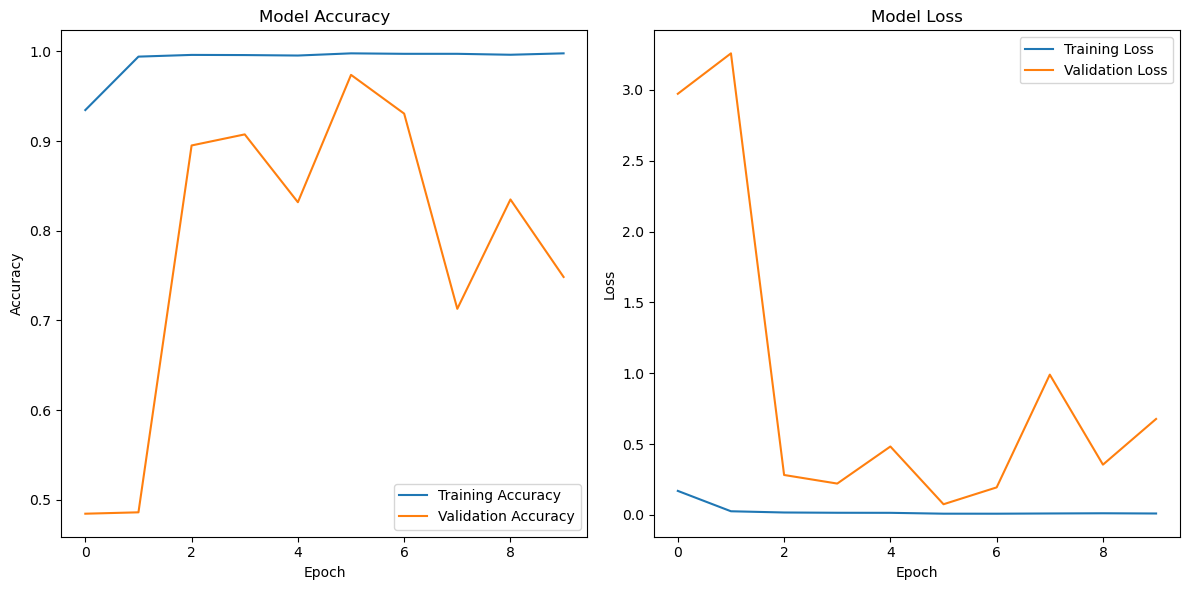

In [19]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(training_accuracy, label='Training Accuracy')
axs[0].plot(validation_accuracy, label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(training_loss, label='Training Loss')
axs[1].plot(validation_loss, label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()

plt.show()

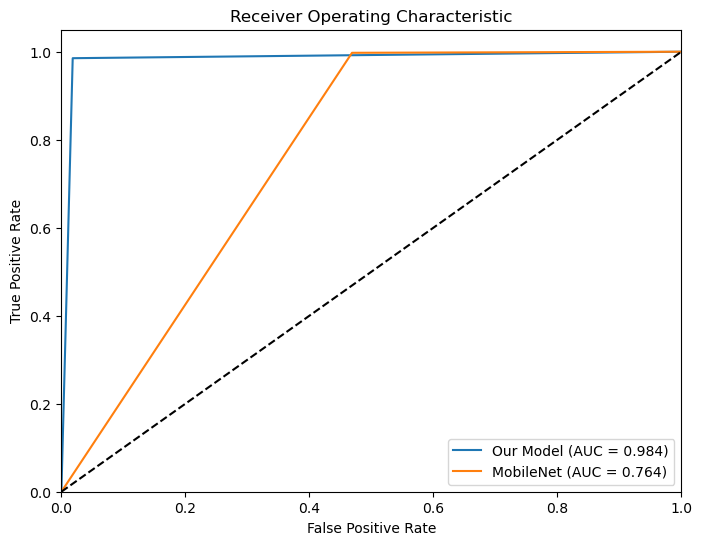

In [20]:
# Compare the two models
fpr_model, tpr_model, thresholds_model = roc_curve(test_Labels, Bi_Predictions)
auc_model = auc(fpr_model, tpr_model)

fpr_mobileNet, tpr_mobileNet, thresholds_mobileNet = roc_curve(test_Labels, test_predictions_labels)
auc_mobileNet = auc(fpr_mobileNet, tpr_mobileNet)

plt.figure(figsize=(8, 6))
plt.plot(fpr_model, tpr_model, label='Our Model (AUC = {:.3f})'.format(auc_model))
plt.plot(fpr_mobileNet, tpr_mobileNet, label='MobileNet (AUC = {:.3f})'.format(auc_mobileNet))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [21]:
from sklearn.metrics import classification_report

# Get the predicted labels for the MobileNet model
mobilenet_predictions_labels = (mobileNetModel.predict(test_Imgs_preprocessed) > 0.5).astype("int32")

# Generate the classification report
report_mobilenet = classification_report(test_Labels, mobilenet_predictions_labels)
print("Classification Report (MobileNet):\n", report_mobilenet)

25/25 [==============================] - 2s 78ms/step
Classification Report (MobileNet):
               precision    recall  f1-score   support

           0       1.00      0.53      0.69       384
           1       0.69      1.00      0.82       408

    accuracy                           0.77       792
   macro avg       0.84      0.76      0.76       792
weighted avg       0.84      0.77      0.76       792



# ResNet50

In [19]:
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# Load the pretrained ResNet model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom layers
x = base_model.output
x = Flatten()(x)
output = Dense(2, activation='softmax')(x)

# Create the final model
resNetModel = Model(inputs=base_model.input, outputs=output)

learning_rate = 1e-4
optimizer = Adam(learning_rate=learning_rate)
resNetModel.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

train_Imgs_preprocessed = preprocess_input(train_Imgs)
val_Imgs_preprocessed = preprocess_input(val_Imgs)
test_Imgs_preprocessed = preprocess_input(test_Imgs)

Epochs = 30
Batch_size = 32

# Convert labels to one-hot encoding
train_Labels_onehot = tf.keras.utils.to_categorical(train_Labels, num_classes=2)
val_Labels_onehot = tf.keras.utils.to_categorical(val_Labels, num_classes=2)
test_Labels_onehot = tf.keras.utils.to_categorical(test_Labels, num_classes=2)

history = resNetModel.fit(train_Imgs_preprocessed,
                          train_Labels_onehot,
                          batch_size=Batch_size,
                          epochs=Epochs,
                          validation_data=(val_Imgs_preprocessed, val_Labels_onehot),
                          callbacks=[EarlyStop])

Epoch 1/30
180/180 [==============================] - 272s 1s/step - loss: 1.1692 - accuracy: 0.4950 - val_loss: 1.3641 - val_accuracy: 0.4846
Epoch 2/30
180/180 [==============================] - 411s 2s/step - loss: 0.8474 - accuracy: 0.5080 - val_loss: 4.3147 - val_accuracy: 0.4846
Epoch 3/30
180/180 [==============================] - 403s 2s/step - loss: 0.8121 - accuracy: 0.5391 - val_loss: 3.4400 - val_accuracy: 0.4846
Epoch 4/30
180/180 [==============================] - 403s 2s/step - loss: 0.7739 - accuracy: 0.6379 - val_loss: 0.7217 - val_accuracy: 0.5154
Epoch 5/30
180/180 [==============================] - 402s 2s/step - loss: 0.6379 - accuracy: 0.7119 - val_loss: 2.5607 - val_accuracy: 0.5154
Epoch 6/30
180/180 [==============================] - 420s 2s/step - loss: 0.5254 - accuracy: 0.7624 - val_loss: 6.8160 - val_accuracy: 0.5154
Epoch 7/30
180/180 [==============================] - 433s 2s/step - loss: 0.5149 - accuracy: 0.7636 - val_loss: 28.1493 - val_accuracy: 0.515

In [20]:
# Evaluating on Validation set
val_predictions = resNetModel.predict(val_Imgs_preprocessed)
val_predictions_labels = np.argmax(val_predictions, axis=1)

val_conf_matrix = confusion_matrix(val_Labels, val_predictions_labels)
val_accuracy = accuracy_score(val_Labels, val_predictions_labels)

print("Accuracy on Validation Set: {:.3f}%".format(val_accuracy * 100))

21/21 [==============================] - 9s 337ms/step
Accuracy on Validation Set: 51.543%


In [21]:
# Evaluating on Test set
test_predictions = resNetModel.predict(test_Imgs_preprocessed)
test_predictions_labels = np.argmax(test_predictions, axis=1)

test_conf_matrix = confusion_matrix(test_Labels, test_predictions_labels)
test_accuracy = accuracy_score(test_Labels, test_predictions_labels)

print("Accuracy on Test Set: {:.3f}%".format(test_accuracy * 100))


25/25 [==============================] - 9s 347ms/step
Accuracy on Test Set: 51.515%


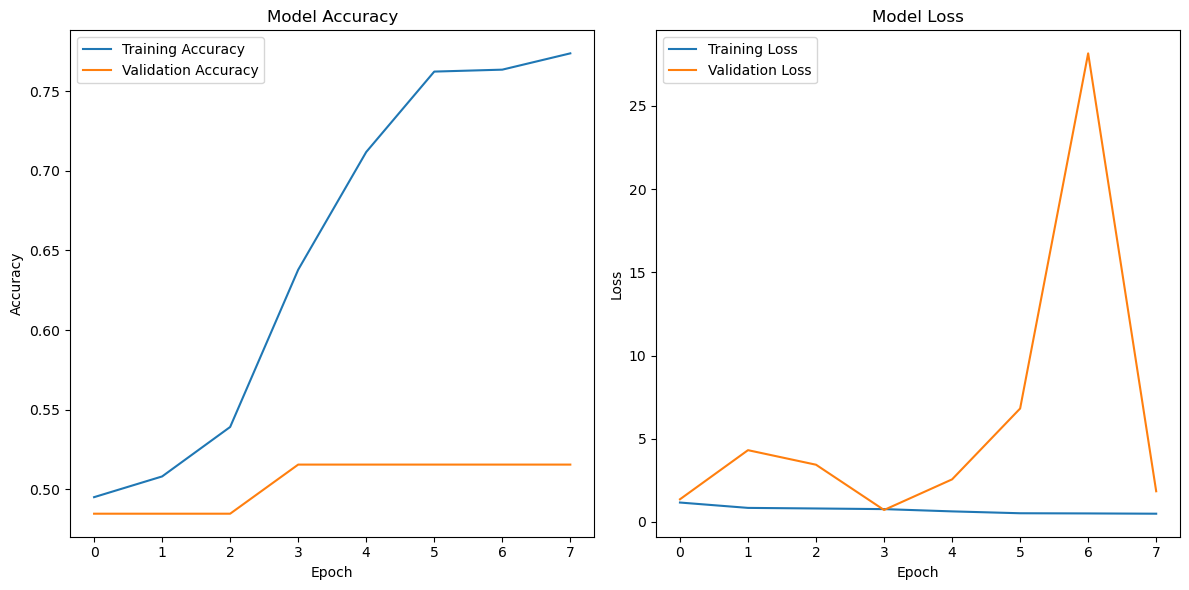

In [22]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(training_accuracy, label='Training Accuracy')
axs[0].plot(validation_accuracy, label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(training_loss, label='Training Loss')
axs[1].plot(validation_loss, label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()

plt.show()

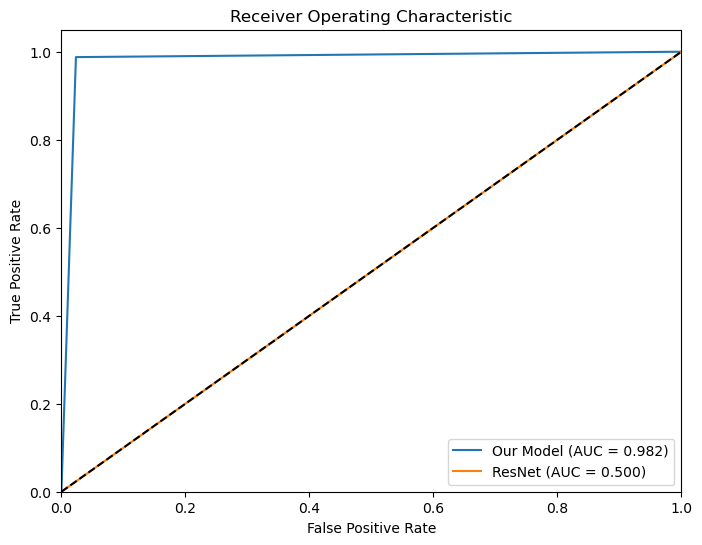

In [23]:
# Compare the two models
fpr_model, tpr_model, thresholds_model = roc_curve(test_Labels, Bi_Predictions)
auc_model = auc(fpr_model, tpr_model)

fpr_resNet, tpr_resNet, thresholds_resNet = roc_curve(test_Labels, test_predictions_labels)
auc_resNet = auc(fpr_resNet, tpr_resNet)

plt.figure(figsize=(8, 6))
plt.plot(fpr_model, tpr_model, label='Our Model (AUC = {:.3f})'.format(auc_model))
plt.plot(fpr_resNet, tpr_resNet, label='ResNet (AUC = {:.3f})'.format(auc_resNet))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [24]:
from sklearn.metrics import classification_report

# Get the predicted labels for the ResNet50 model
resnet_predictions_labels = resNetModel.predict(test_Imgs_preprocessed).argmax(axis=1)

# Generate the classification report
report_resnet = classification_report(test_Labels, resnet_predictions_labels, zero_division=1)
print("Classification Report (ResNet50):\n", report_resnet)

25/25 [==============================] - 9s 352ms/step
Classification Report (ResNet50):
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       384
           1       0.52      1.00      0.68       408

    accuracy                           0.52       792
   macro avg       0.76      0.50      0.34       792
weighted avg       0.75      0.52      0.35       792



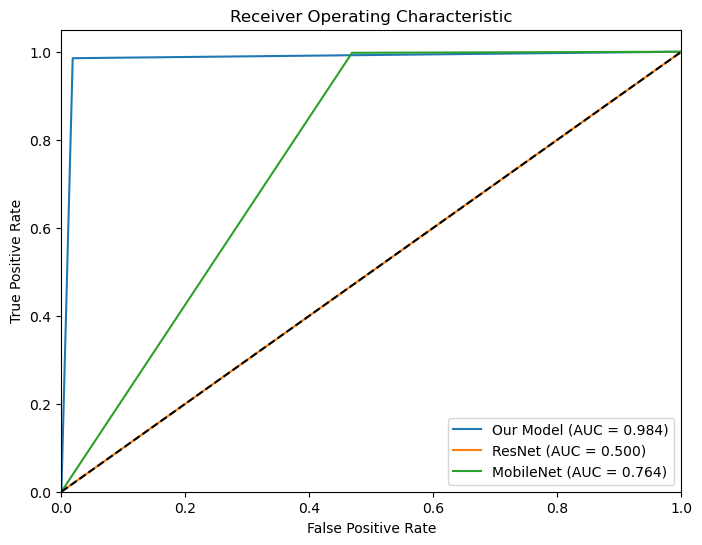

In [30]:
import matplotlib.pyplot as plt

# Compare the three models
fpr_model, tpr_model, thresholds_model = roc_curve(test_Labels, Bi_Predictions)
auc_model = auc(fpr_model, tpr_model)

fpr_resNet, tpr_resNet, thresholds_resNet = roc_curve(test_Labels, resnet_predictions_labels)
auc_resNet = auc(fpr_resNet, tpr_resNet)

fpr_mobileNet, tpr_mobileNet, thresholds_mobileNet = roc_curve(test_Labels, mobilenet_predictions_labels)
auc_mobileNet = auc(fpr_mobileNet, tpr_mobileNet)

plt.figure(figsize=(8, 6))
plt.plot(fpr_model, tpr_model, label='Our Model (AUC = {:.3f})'.format(auc_model))
plt.plot(fpr_resNet, tpr_resNet, label='ResNet (AUC = {:.3f})'.format(auc_resNet))
plt.plot(fpr_mobileNet, tpr_mobileNet, label='MobileNet (AUC = {:.3f})'.format(auc_mobileNet))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()